### Step 01 :  임포트  

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import tensorflow.python.keras.backend as k


### Step 02 :  이미지 , 마스크 배열로 리턴 

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1


#데이터 경로 지정  
TRAIN_PATH = './Segmentation01/train/'
TEST_PATH = './Segmentation01/test/'

# UserWarning을 무시하는 설정(없음 OK)
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#이미지 파일명을 리스트 형식으로 리턴  
train_imgs = glob.glob(TRAIN_PATH+'org/*.png')
train_masks = glob.glob(TRAIN_PATH+'label/*.png')
test_imgs = glob.glob(TEST_PATH+'org/*.png')
test_masks = glob.glob(TEST_PATH+'label/*.png')

#리스트 길이 리턴  
num_of_train_imgs = len(train_imgs)
num_of_train_masks = len(train_masks)
if num_of_train_imgs != num_of_train_masks:
    print('invalid datasets, please check train data')
    
    
#각이미지를 배열로 리턴
#image 
X_train = np.zeros((num_of_train_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# mask
Y_train = np.zeros((num_of_train_masks, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n in range(num_of_train_imgs):
    X_train[n] = imread(train_imgs[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    Y_train[n] = imread(train_masks[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


# 테스트 이미지를 배열로 리턴
X_test = np.zeros((len(test_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_masks), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting test images ... ')
sys.stdout.flush()

for n in range(len(test_imgs)):
    X_test[n] = imread(test_imgs[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    Y_test[n] = imread(test_masks[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('Preparing is Done!')


Getting and resizing train images and masks ... 
Getting test images ... 
Preparing is Done!


### step03 이미지 확인 

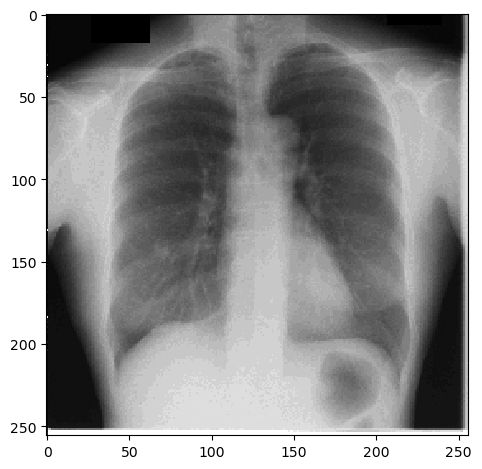

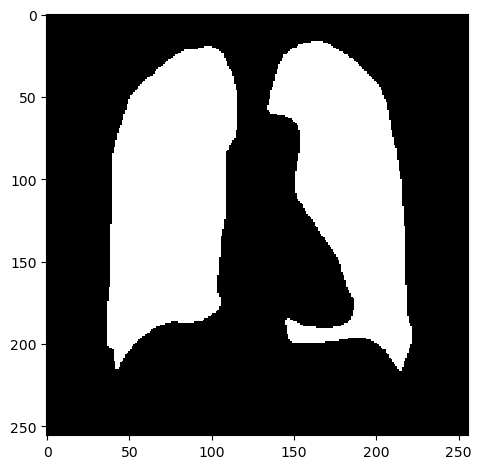

In [5]:
###이미지 확인 #####
ix = random.randint(0, len(train_imgs))
imshow(X_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(np.squeeze(Y_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()

### step 05  U-NET model

In [6]:
# U-Net model 
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255.) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (p1)
c2 = LeakyReLU()(c2)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (p2)
c3 = LeakyReLU()(c3)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c3)
c3 = LeakyReLU()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (p3)
c4 = LeakyReLU()(c4)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c4)
c4 = LeakyReLU()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu',kernel_initializer='he_normal', padding='same') (c5)

##############################################################
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (u6)
c6 = LeakyReLU()(c6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c6)
c6 = LeakyReLU()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u7)
c7 = LeakyReLU()(c7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c7)
c7 = LeakyReLU()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
c8 = LeakyReLU()(c8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
c8 = LeakyReLU()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization(momentum=0.9) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

### step 06 : 컴파일 모델 확인

In [7]:
model.compile(optimizer=Nadam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['binary_accuracy','acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                               

 conv2d_11 (Conv2D)          (None, 32, 32, 128)          147584    ['batch_normalization_5[0][0]'
                                                                    ]                             
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 128)          0         ['conv2d_11[0][0]']           
                                                                                                  
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 64)           32832     ['leaky_re_lu_7[0][0]']       
 Transpose)                                                                                       
                                                                                                  
 concatenate_1 (Concatenate  (None, 64, 64, 128)          0         ['conv2d_transpose_1[0][0]',  
 )                                                                   'leaky_re_lu_3[0][0]']       
          

### step 07 :  모델 학습

In [8]:
checkpointer = ModelCheckpoint('model-u-net.h5', verbose=1, save_best_only=True)
reduceLr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=7)

results = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=3, 
                    epochs=50,
                    callbacks=[reduceLr, checkpointer])


Epoch 1/50


15/15 [==============================] - ETA: 0s - loss: -86.2814 - binary_accuracy: 0.5047 - acc: 0.5047
Epoch 1: val_loss improved from inf to 81.85004, saving model to model-u-net.h5


C:\Users\taeeon.kim\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 22s 417ms/step - loss: -86.2814 - binary_accuracy: 0.5047 - acc: 0.5047 - val_loss: 81.8500 - val_binary_accuracy: 0.7025 - val_acc: 0.7025 - lr: 2.0000e-05
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: -117.2363 - binary_accuracy: 0.5028 - acc: 0.5028
Epoch 2: val_loss did not improve from 81.85004
15/15 [==============================] - 5s 326ms/step - loss: -117.2363 - binary_accuracy: 0.5028 - acc: 0.5028 - val_loss: 98.1080 - val_binary_accuracy: 0.6625 - val_acc: 0.6625 - lr: 2.0000e-05
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: -153.7537 - binary_accuracy: 0.4981 - acc: 0.4981
Epoch 3: val_loss did not improve from 81.85004
15/15 [==============================] - 5s 317ms/step - loss: -153.7537 - binary_accuracy: 0.4981 - acc: 0.4981 - val_loss: 100.3446 - val_binary_accuracy: 0.6090 - val_acc: 0.6090 - lr: 2.0000e-05
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: -192.

Epoch 22/50
15/15 [==============================] - ETA: 0s - loss: -791.7192 - binary_accuracy: 0.6358 - acc: 0.6358
Epoch 22: val_loss improved from -517.43225 to -533.72308, saving model to model-u-net.h5
15/15 [==============================] - 5s 302ms/step - loss: -791.7192 - binary_accuracy: 0.6358 - acc: 0.6358 - val_loss: -533.7231 - val_binary_accuracy: 0.6208 - val_acc: 0.6208 - lr: 2.0000e-05
Epoch 23/50
15/15 [==============================] - ETA: 0s - loss: -818.4952 - binary_accuracy: 0.6409 - acc: 0.6409
Epoch 23: val_loss improved from -533.72308 to -660.06769, saving model to model-u-net.h5
15/15 [==============================] - 5s 327ms/step - loss: -818.4952 - binary_accuracy: 0.6409 - acc: 0.6409 - val_loss: -660.0677 - val_binary_accuracy: 0.6115 - val_acc: 0.6115 - lr: 2.0000e-05
Epoch 24/50
15/15 [==============================] - ETA: 0s - loss: -841.2932 - binary_accuracy: 0.6428 - acc: 0.6428
Epoch 24: val_loss did not improve from -660.06769
15/15 [=====

15/15 [==============================] - 5s 319ms/step - loss: -1228.6440 - binary_accuracy: 0.6699 - acc: 0.6699 - val_loss: -1176.5751 - val_binary_accuracy: 0.6683 - val_acc: 0.6683 - lr: 2.0000e-05
Epoch 43/50
15/15 [==============================] - ETA: 0s - loss: -1248.3015 - binary_accuracy: 0.6705 - acc: 0.6705
Epoch 43: val_loss did not improve from -1176.57507
15/15 [==============================] - 4s 292ms/step - loss: -1248.3015 - binary_accuracy: 0.6705 - acc: 0.6705 - val_loss: -1173.4807 - val_binary_accuracy: 0.6724 - val_acc: 0.6724 - lr: 2.0000e-05
Epoch 44/50
15/15 [==============================] - ETA: 0s - loss: -1266.3325 - binary_accuracy: 0.6715 - acc: 0.6715
Epoch 44: val_loss improved from -1176.57507 to -1218.60559, saving model to model-u-net.h5
15/15 [==============================] - 5s 305ms/step - loss: -1266.3325 - binary_accuracy: 0.6715 - acc: 0.6715 - val_loss: -1218.6056 - val_binary_accuracy: 0.6680 - val_acc: 0.6680 - lr: 2.0000e-05
Epoch 45/5

### step 08: 학습 후 테스트 데이터로 예측 결과 확인

In [9]:

model = load_model('model-u-net.h5')
preds_test = model.predict(X_test, verbose=1)

#픽셀  평가 결과를 0.5의 임계치로 0 or 255로 변환(평가 결과를 바이너리 이미지로 변환).
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# 임의 결과로 하나를 리턴 받아 표시 
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(Y_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(np.squeeze(preds_test_t[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()

1/1 [==============================] - 1s 778ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10